# <h1>Homework 3

# <h1> Problem 1

For a binary mixture with two adjustable parameters $A_{12}$ and $A_{21}$ equilibrium relations are <br/>
$p = x_1\;exp(A_{12}(\frac{A_{21}x_2}{A_{12}x_1 + A_{21}x_2})^2)p_{water}^{sat} + x_2\;exp(A_{21}(\frac{A_{12}x_1}{A_{12}x_1 + A_{21}x_2})^2)p_{1,4\;dioxane}^{sat}$
<br/> The saturation pressure is given as,
<br/> $log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3}$
<br/> We have also been given that,
<br/> $x_1 + x_2 = 1$
<br/> A table of measures for $x_1$ and corresponding $p$ is also given
<br/> We need to solve this problem like a least squares problem

# <h2> Part 1

Least Squares formulation
<br/> $min_{A_{12},A_{21}} \sum (p - p(A_{12},A_{21}))^{2}$
<br/> This means that we need to minimize the sum of squared difference all actual $p$ and calculated $p$ by modifying $As$.

#<h2> Part 2

In order to get a solution as close as possible to the optimum solution, we cannot linearize the given model.
<br/> To solve the problem with its non-linearity intact we solve the problem using gradient descent.

In [64]:
# Calculate p_sat from the formula given
def p_sat(a1,a2,a3):
    return 10**(a1 - ((a2)/(a3+20)))

In [65]:
p_water = p_sat(8.07131,1730.63,233.426)
p_diox = p_sat(7.43155,1554.679,240.337)

In [51]:
import torch as t
from torch.autograd import Variable
import numpy as np

In [52]:
# Setup Cost Function, calling it sat
def sat(x1,x2,p_water,p_diox,x):
    return x1*t.exp(x[0]*((x[1]*x2)/(x[0]*x1 + x[1]*x2))**2)*p_water + x2*t.exp(x[1]*((x[0]*x1)/(x[0]*x1 + x[1]*x2))**2)*p_diox

In [53]:
# Generate x1
x1 = t.tensor(np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]))
# x2 is given as 1-x1
x2 = 1-x1

In [55]:
p = t.tensor([28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5])

In [56]:
def square_loss(act,pred):
    loss = act-pred # Calculate difference of Predicted and Actual p
    loss = loss**2 # Square of the difference
    return t.sum(loss) # Return Sum of Squares for LSE

In [194]:
lossx = np.array([])
x_all = np.array([])
a = 0.001 # Setting Learning rate to 0.001
x = Variable(t.tensor([1.0,1.0]),requires_grad = True) # Encoding variables A12 and A21
for i in range(1000): # Running for 1000 epochs
    p_pred = sat(x1,x2,p_water,p_diox,x) # Calculating Predicted P from formula
    loss = square_loss(p,p_pred) # Calculating loss between actual and predicted
    loss.backward() # Compute Gradient
    with t.no_grad(): # Avoid Gradient Computation
        x -=a*x.grad # Update variables with step
        x.grad.zero_() # Clear Gradient to avoid saturation
        #print(loss.data.numpy())
        lossx = np.append(lossx,loss.data.numpy()) #Store loss to plot convergence
        x_all = np.append(x_all,x.data.numpy()) #Store all values of A12 and A21

In [180]:
print('The value for A12 = '+str(x.data.numpy()[0])+'and A21 = '+str(x.data.numpy()[1])+'\n')
print('The converged loss of the solution = '+str(loss.data.numpy()))

The value for A12 = 1.9584194and A21 = 1.6891854

The converged loss of the solution = 0.6701930714829456


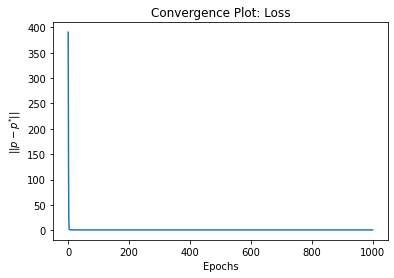

In [190]:
# Plotting Performance
import matplotlib.pyplot as plt
plt.figure(1);plt.clf()
plt.plot(lossx)
plt.xlabel('Epochs')
plt.ylabel('$||p-p^{*}||$')
plt.title('Convergence Plot: Loss')
plt.show()

# <h3> Part 3

In this part we compare the optimized model prediction with the actual data.

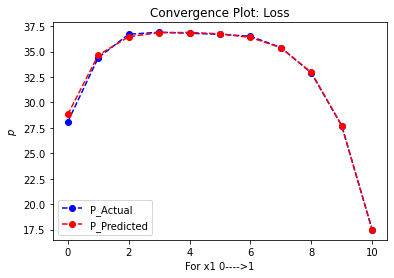

In [204]:
plt.figure(1);plt.clf()
plt.plot(p,'bo--')
plt.plot(p_pred.detach().numpy(),'ro--')
plt.xlabel('For x1 0---->1')
plt.ylabel('$p$')
plt.legend(['P_Actual','P_Predicted'])
plt.title('Convergence Plot: Loss')
plt.show()

From the above diagram it is clear that the gradient descent has optimized our model. The predicted values for p
fit very well with the actual data provided. Thus, we can be assured that the calculated $A_{12}$ and
$A_{21}$ are accurate.

# <h2> Problem 2

In this problem we are required to minimize,
<br/> $min_{x_{1},x_{2}} (4 - 2.1x_{1}^2 + \frac{x_{1}^4}{3})x_{1}^2 + x_{1}x_{2} + (-4 + 4x_{2}^2)x_{2}^2$
<br/> where, $x_{1} \in [-3,3]$ and $x_{2} \in [-2,2]$

In [221]:
# Importing Libraries
from matplotlib import cm #Colormap for surface plot
from skopt import gp_minimize # We use Bayesian Optimization from this library
from skopt.space import Real # This allows us to encode variables to optimize along with bounds

In [94]:
# Defining function to minimize
def cost_fun(x):
    return ((4 - 2.1*(x[0]**2) + (x[0]**4)/3)*(x[0]**2)) + x[0]*x[1] + (-4 + 4*(x[1]**2))*(x[1]**2)

-1.02614400718987
(array([16, 33], dtype=int64), array([25, 24], dtype=int64))
-0.06122448979591866
-0.6938775510204083


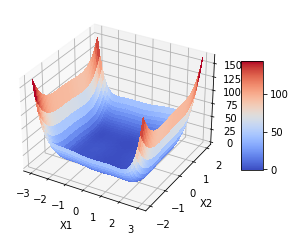

In [249]:
# Plotting Region to Optimize
x1_line = np.linspace(-3,3,num=50)
x2_line = np.linspace(-2,2,num=50)
x1_line,x2_line = np.meshgrid(x1_line,x2_line)
z_line = cost_fun([x1_line,x2_line])
print(np.amin(z_line))# Roughly the minimum of this cost function that needs to be achieved
print(np.where(z_line==np.amin(z_line)))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1_line,x2_line,z_line, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Z')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [212]:
# Defining the two variables x1 and x2 as Real Numbers along with their given bounds
space = [Real(-3,3),Real(-2,2)]
# Running 50 iterations of Bayesian Optimization to evaluate the best parameter combination to minimize cost function
res = gp_minimize(cost_fun,space,x0=[0,1],acq_func="EI",n_calls=50,n_random_starts=5,random_state=123,noise=0.1**2)

In [248]:
print(res.x)

[-0.08832222439641102, 0.6773414104897277]
